# Logit Difference Frequency Analysis
This notebook processes multiple JSON files and computes the frequency of avg_logits difference between error_step and fix_step.

In [33]:
# 挂载 Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# 设置文件夹路径
FOLDER_PATH = '/content/drive/MyDrive/Cluster-proj/output/stat_logits/'

# 存储所有合法的 diff 值
diffs = []

# 遍历文件夹中的所有 json 文件
for filename in os.listdir(FOLDER_PATH):
    if not filename.endswith('.json'):
        continue
    filepath = os.path.join(FOLDER_PATH, filename)
    try:
        with open(filepath, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Failed to load {filename}: {e}")
        continue

    for qid, content in data.items():
        correct_sampling = content.get('correct_sampling', {})
        wrong_sampling = content.get('wrong_sampling', {})

        for wrong_samp, wrong_vs_dict in wrong_sampling.items():
            for vs_corr, wrong_pair in wrong_vs_dict.items():
                if not isinstance(wrong_pair, dict):
                    continue
                err_logit = wrong_pair.get('avg_logits', None)
                if err_logit is None:
                    continue

                try:
                    c_samp = vs_corr.split('vs_')[-1]
                    w_samp = wrong_samp
                    corr_pair = correct_sampling.get(c_samp, {}).get(f'vs_{w_samp}', {})
                    fix_logit = corr_pair.get('avg_logits', None)
                    if fix_logit is None:
                        continue

                    diff = round(float(err_logit) - float(fix_logit), 2)
                    if -1 <= diff <= 1:
                        diffs.append(diff)

                    break  # ✅ 确保一个 wrong step 只比较一个 fix step
                except Exception as e:
                    print(f"Error processing {qid} {wrong_samp} vs {vs_corr}: {e}")
                    continue


In [35]:
# 统计频率
histogram = defaultdict(int)
for d in diffs:
    histogram[d] += 1

# 输出统计结果
sorted_keys = sorted(histogram.keys())
print("Logit Diff Frequencies [-1 to +1]:")
for k in sorted_keys:
    print(f"{k:.2f}: {histogram[k]}")


Logit Diff Frequencies [-1 to +1]:
-0.17: 2
-0.16: 1
-0.15: 1
-0.14: 2
-0.13: 2
-0.12: 3
-0.11: 6
-0.10: 4
-0.09: 7
-0.08: 7
-0.07: 8
-0.06: 13
-0.05: 7
-0.04: 20
-0.03: 17
-0.02: 17
-0.01: 18
0.00: 21
0.01: 18
0.02: 10
0.03: 5
0.04: 8
0.05: 3
0.06: 8
0.07: 2
0.09: 4
0.10: 4
0.11: 3
0.12: 1
0.14: 1


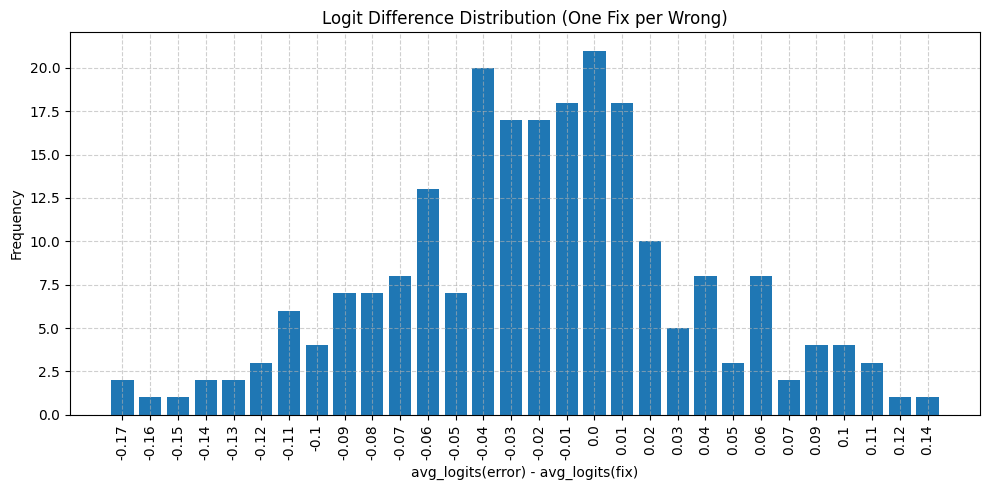

In [36]:
# 可视化频率分布
plt.figure(figsize=(10, 5))
plt.bar([str(k) for k in sorted_keys], [histogram[k] for k in sorted_keys])
plt.xlabel('avg_logits(error) - avg_logits(fix)')
plt.ylabel('Frequency')
plt.title('Logit Difference Distribution (One Fix per Wrong)')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [37]:
if diffs:
    mean_diff = sum(diffs) / len(diffs)
    print(f"Mean diff: {mean_diff:.4f}")
else:
    print("No valid diff values found.")


Mean diff: -0.0195


In [39]:
if diffs:
    diffs_np = np.array(diffs)

    mean_diff = np.mean(diffs_np)
    median_diff = np.median(diffs_np)
    std_diff = np.std(diffs_np)
    min_diff = np.min(diffs_np)
    max_diff = np.max(diffs_np)
    percentile_25 = np.percentile(diffs_np, 25)
    percentile_75 = np.percentile(diffs_np, 75)

    print(f"📊 Diff Statistics:")
    print(f"  Mean     : {mean_diff:.4f}")
    print(f"  Median   : {median_diff:.4f}")
    print(f"  Std Dev  : {std_diff:.4f}")
    print(f"  Min      : {min_diff:.4f}")
    print(f"  25%tile  : {percentile_25:.4f}")
    print(f"  75%tile  : {percentile_75:.4f}")
    print(f"  Max      : {max_diff:.4f}")
else:
    print("No valid diff values found.")


📊 Diff Statistics:
  Mean     : -0.0195
  Median   : -0.0200
  Std Dev  : 0.0569
  Min      : -0.1700
  25%tile  : -0.0550
  75%tile  : 0.0100
  Max      : 0.1400
